IMPORT THƯ VIỆN VÀ SETUP DATA

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

batch_size = 64
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(trainset, batch_size, shuffle = True)
test_loader = DataLoader(testset, batch_size, shuffle = False)

XÂY DỰNG CNN


In [ ]:


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # 4 conv
        self.conv1 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)

        # BatchNorm
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # 32x32 -> pool -> 16x16 -> pool -> 8x8
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):
        # Conv block 1
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))  # 32->16
        # Conv block 2
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))  # 16->8
        # Conv block 3 + 4
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.leaky_relu(self.bn4(self.conv4(x)))

        # Flatten
        x = x.view(x.size(0), -1)

        # FC
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = self.fc4(x)
        return x


Loss function + Optimizer


In [3]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print('using', device)
model = CNN().to(device)  
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

using cuda


Training


In [4]:
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

Epoch [1/30] - Loss: 1.4162
Epoch [2/30] - Loss: 1.0094
Epoch [3/30] - Loss: 0.8406
Epoch [4/30] - Loss: 0.7274
Epoch [5/30] - Loss: 0.6329
Epoch [6/30] - Loss: 0.5550
Epoch [7/30] - Loss: 0.4793
Epoch [8/30] - Loss: 0.4105
Epoch [9/30] - Loss: 0.3500
Epoch [10/30] - Loss: 0.2940
Epoch [11/30] - Loss: 0.2480
Epoch [12/30] - Loss: 0.2103
Epoch [13/30] - Loss: 0.1838
Epoch [14/30] - Loss: 0.1568
Epoch [15/30] - Loss: 0.1386
Epoch [16/30] - Loss: 0.1233
Epoch [17/30] - Loss: 0.1167
Epoch [18/30] - Loss: 0.1039
Epoch [19/30] - Loss: 0.1002
Epoch [20/30] - Loss: 0.0857
Epoch [21/30] - Loss: 0.0878
Epoch [22/30] - Loss: 0.0832
Epoch [23/30] - Loss: 0.0737
Epoch [24/30] - Loss: 0.0748
Epoch [25/30] - Loss: 0.0705
Epoch [26/30] - Loss: 0.0675
Epoch [27/30] - Loss: 0.0651
Epoch [28/30] - Loss: 0.0591
Epoch [29/30] - Loss: 0.0592
Epoch [30/30] - Loss: 0.0575


In [5]:
#test
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 82.05%


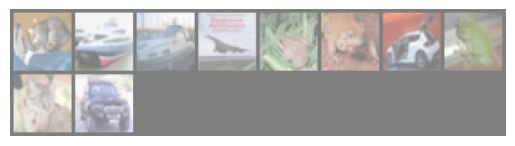

GroundTruth:  cat | ship | ship | plane | frog | frog | car | frog | cat | car
Predicted:    cat | ship | ship | plane | frog | frog | truck | frog | cat | car


In [6]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)

model.eval()
with torch.no_grad():
    outputs = model(images.to(device))
    _, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images[:10]))
print('GroundTruth: ', ' | '.join(f'{classes[labels[j]]}' for j in range(10)))
print('Predicted:   ', ' | '.join(f'{classes[predicted[j]]}' for j in range(10)))


In [7]:
torch.save(model.state_dict(), "cnn_cifar10.pth")